# At a glance

In [1]:
import pandas as pd
df = pd.read_csv('../data/hotel_bookings.csv')
features = pd.read_csv('../data/feature_description.csv', header=None)
features.columns = ['feature', 'description']

In [3]:
pd.set_option("display.max_colwidth", 200)
pd.merge(features, df.describe().T, left_on='feature', right_index=True, how="right")

,feature,description,count,mean,std,min,25%,50%,75%,max
1,is_canceled,order canceled (1) or not (0),119390.0,0.370416,0.482918,0.00,0.00,0.000,1.0,1.0
2,lead_time,Number of days that elapsed between the entering date of the booking into the PMS and the arrival date,119390.0,104.011416,106.863097,0.00,18.00,69.000,160.0,737.0
3,arrival_date_year,Year of arrival date,119390.0,2016.156554,0.707476,2015.00,2016.00,2016.000,2017.0,2017.0
5,arrival_date_week_number,Week number of year for arrival date,119390.0,27.165173,13.605138,1.00,16.00,28.000,38.0,53.0
6,arrival_date_day_of_month,Day of arrival date,119390.0,15.798241,8.780829,1.00,8.00,16.000,23.0,31.0
7,stays_in_weekend_nights,Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel,119390.0,0.927599,0.998613,0.00,0.00,1.000,2.0,19.0
8,stays_in_week_nights,Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel,119390.0,2.500302,1.908286,0.00,1.00,2.000,3.0,50.0
9,adults,Number of adults,119390.0,1.856403,0.579261,0.00,2.00,2.000,2.0,55.0
10,children,Number of children,119386.0,0.103890,0.398561,0.00,0.00,0.000,0.0,10.0
11,babies,Number of babies,119390.0,0.007949,0.097436,0.00,0.00,0.000,0.0,10.0


# Prepocessing

In [4]:
import numpy as np
for col in df.columns:
    if df[col].dtype == 'object' and col != 'country':
        df.loc[df[col].str.contains('NULL'), col] = np.nan
        df.loc[df[col].str.contains('Undefined', na=False), col] = np.nan
null_series = df.isnull().sum()
print(null_series[null_series > 0])

children                     4
meal                      1169
country                    488
market_segment               2
distribution_channel         5
agent                    16340
company                 112593
dtype: int64


In [5]:
subset = [
    'country',      
    'children',      
    'market_segment',      
    'distribution_channel'
] 
df = df.dropna(subset=subset)

In [6]:
df.loc[df.agent.isnull(), 'agent'] = 999 
df.loc[df.company.isnull(), 'company'] = 999
df.loc[df.meal.isnull(), 'meal'] = 'SC'

In [7]:
df = df[df.adr > 0]

## Outliers

In [8]:

cleaned = df.copy()

columns = [
    'lead_time',
    'stays_in_weekend_nights',
    'stays_in_week_nights',
    'adults',
    'children',
    'babies',
    'adr',
]

for col in columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)

    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    print(f'Lower point: {round(lower, 2)} \t upper point: {round(upper, 2)} \t {col}')
    
    if lower == upper:
        continue
    
    cond1 = (cleaned[col] >= lower) & (cleaned[col] <= upper)
    cond2 = cleaned[col].isnull()
    cleaned = cleaned[cond1 | cond2]

Lower point: -195.5 	 upper point: 376.5 	 lead_time
Lower point: -3.0 	 upper point: 5.0 	 stays_in_weekend_nights
Lower point: -2.0 	 upper point: 6.0 	 stays_in_week_nights
Lower point: 2.0 	 upper point: 2.0 	 adults
Lower point: 0.0 	 upper point: 0.0 	 children
Lower point: 0.0 	 upper point: 0.0 	 babies
Lower point: -11.5 	 upper point: 208.5 	 adr


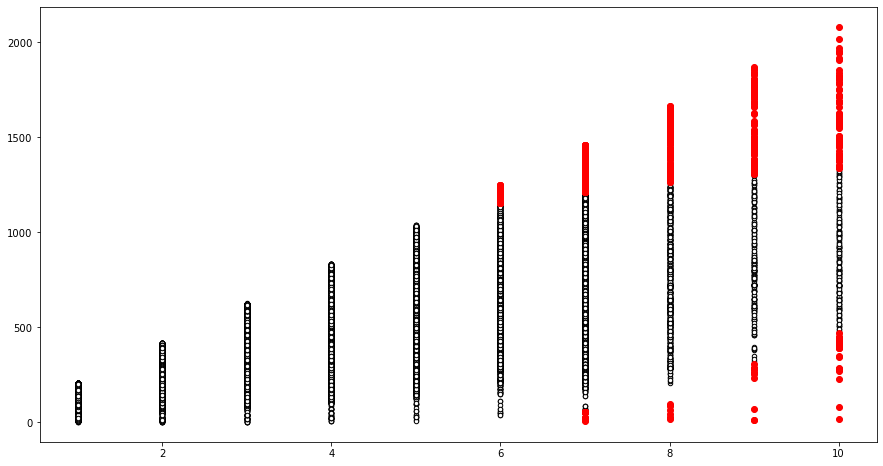

In [9]:
from sklearn.covariance import EllipticEnvelope
import matplotlib.pyplot as plt
import numpy as np
# create new features: total price and total nights
cleaned.loc[:, 'total_nights'] = \
cleaned['stays_in_week_nights'] + cleaned['stays_in_weekend_nights']
cleaned.loc[:, 'price'] = cleaned['adr'] * cleaned['total_nights']
# create numpy array
X = np.array(cleaned[['total_nights', 'price']])
# create model 
ee = EllipticEnvelope(contamination=.01, random_state=0)
# predictions 
y_pred_ee = ee.fit_predict(X)
# predictions (-1: outlier, 1: normal)
anomalies = X[y_pred_ee == -1]
# plot data and outliers
plt.figure(figsize=(15, 8))
plt.scatter(X[:, 0], X[:, 1], c='white', s=20, edgecolor='k')
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='red');

In [10]:
df_cleaned = cleaned[y_pred_ee != -1].copy()
df_cleaned.to_csv('../data/hotel_bookings_cleaned.csv', index=False)

# Feature Engineering

In [11]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
df_cleaned = pd.read_csv('../data/hotel_bookings_cleaned.csv')
# train = pd.read_csv('./data/H1_cleaned.csv')
# test = pd.read_csv('./data/H2_cleaned.csv')
train = df_cleaned[df_cleaned.hotel=="Resort Hotel"].drop('hotel', axis=1)
test = df_cleaned[df_cleaned.hotel=="City Hotel"].drop('hotel', axis=1)
train

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,total_nights,price
0,0,7,2015,July,27,1,0,1,1,0.0,...,999.0,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,75.00
1,0,13,2015,July,27,1,0,1,1,0.0,...,999.0,0,Transient,75.00,0,0,Check-Out,2015-07-02,1,75.00
2,0,14,2015,July,27,1,0,2,2,0.0,...,999.0,0,Transient,98.00,0,1,Check-Out,2015-07-03,2,196.00
3,0,14,2015,July,27,1,0,2,2,0.0,...,999.0,0,Transient,98.00,0,1,Check-Out,2015-07-03,2,196.00
4,0,0,2015,July,27,1,0,2,2,0.0,...,999.0,0,Transient,107.00,0,0,Check-Out,2015-07-03,2,214.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32369,0,21,2017,August,35,31,2,5,2,0.0,...,999.0,0,Contract,101.70,0,2,Check-Out,2017-09-07,7,711.90
32370,0,279,2017,August,35,31,2,5,2,0.0,...,999.0,0,Contract,72.20,0,1,Check-Out,2017-09-07,7,505.40
32371,0,191,2017,August,35,31,2,5,2,0.0,...,999.0,0,Contract,114.80,0,0,Check-Out,2017-09-07,7,803.60
32372,0,227,2017,August,35,31,2,5,2,1.0,...,999.0,0,Transient,127.58,0,1,Check-Out,2017-09-07,7,893.06


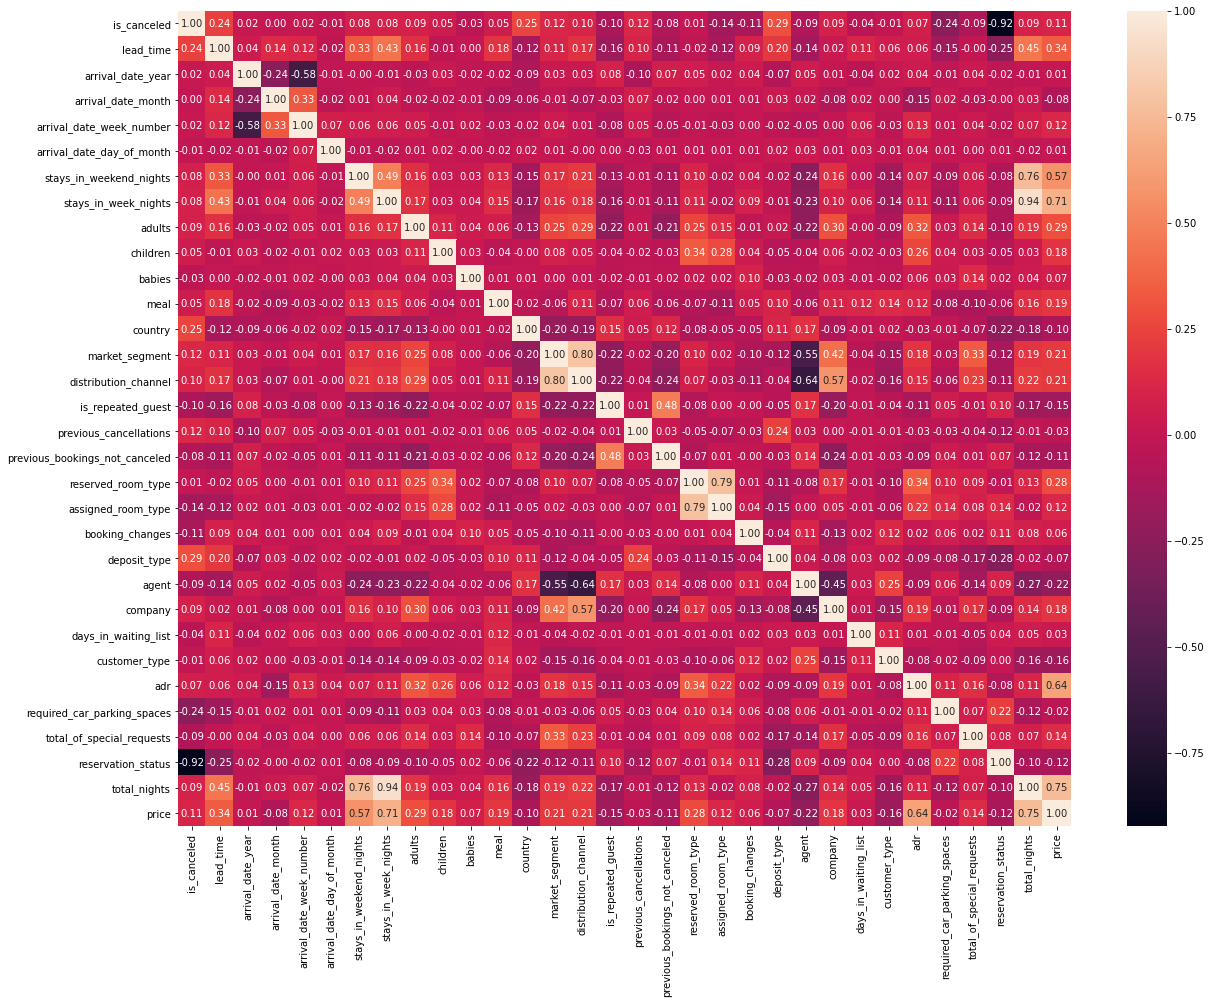

In [12]:
df_le = train.copy()
le = LabelEncoder()

categoricals = [
    'arrival_date_month',
    'meal',
    'country',
    'market_segment',
    'distribution_channel',
    'reserved_room_type',
    'assigned_room_type',
    'deposit_type',
    'agent',
    'company',
    'customer_type',
    'reservation_status',
]

for col in categoricals:
    df_le[col] = le.fit_transform(df_le[col])
plt.figure(figsize=(20, 15))
sns.heatmap(df_le.corr(), annot=True, fmt='.2f');

In [13]:
columns = [
    'reservation_status_date',
    'total_nights',
    'reservation_status',
]

train = train.drop(columns, axis=1)
test = test.drop(columns, axis=1)
df_le = df_le.drop(columns, axis=1)


In [14]:

import pandas as pd
new_categoricals = [col for col in categoricals if col in train.columns]
df_hot = pd.get_dummies(data=train, columns=new_categoricals)
test_hot = pd.get_dummies(data=test, columns=new_categoricals)
X_hot = df_hot.drop('is_canceled', axis=1)
X_le = df_le.drop('is_canceled', axis=1)
y = train['is_canceled']

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
X_train, X_test, y_train, y_test = train_test_split(X_hot, y, test_size=.2, random_state=42)

log = LogisticRegression().fit(X_train, y_train)
y_pred = log.predict(X_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

0.827953667953668
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4735
           1       0.78      0.50      0.61      1740

    accuracy                           0.83      6475
   macro avg       0.81      0.72      0.75      6475
weighted avg       0.82      0.83      0.81      6475



C:\Users\oyrx\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


# Feature selection

In [16]:
def select(X):
    selects = []
    
    selector = SelectKBest(chi2, k='all').fit(X, y)
    scores = selector.scores_
        
    q3 = np.quantile(scores, 0.75)
    q1 = np.quantile(scores, 0.25)
    iqr = q3 - q1
    threshold = q3 + 1.5 * iqr

    for col, val in zip(X.columns, scores):
        cond1 = val > threshold
        cond2 = col in test_hot.columns or col in test.columns
        
        if cond1 and cond2:
            if col not in test_hot.columns:
                test_hot.loc[:, col] = 0
            selects.append(col)
        
    return selects


selects_hot = select(X_hot)
selects_le = select(X_le)

In [19]:
def compare():
    for is_le in [True, False]:
        method = 'label encoder'
        
        if is_le:
            selected = df_le[selects_le + ['is_canceled']]
        else:
            selected = df_hot[selects_hot + ['is_canceled']]
            method = 'dummy variables'
        
        # separate majority and minority classes
        major = selected[selected['is_canceled'] == 0]
        minor = selected[selected['is_canceled'] == 1]

        # downsample majority class
        downsampled = resample(major, replace=False, n_samples=len(minor), random_state=123) 

        # combine minority class with downsampled majority class
        df_new = pd.concat([downsampled, minor])
    
        X = df_new.drop('is_canceled', axis=1)
        y = df_new['is_canceled']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

        log = LogisticRegression().fit(X_train, y_train)
        y_pred = log.predict(X_test)

        print(f'Accuracy for {method}: {accuracy_score(y_test, y_pred)}')
        print(f'Classification report for {method}:\n{classification_report(y_test, y_pred)}')


In [20]:
compare()

NameError: name 'resample' is not defined

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pandas as pd
last = test_hot[selects_hot + ['is_canceled']]

X_last = last.drop('is_canceled', axis=1)
y_last = last['is_canceled']
selected = df_hot[selects_hot + ['is_canceled']]
# separate majority and minority classes
major = selected[selected['is_canceled'] == 0]
minor = selected[selected['is_canceled'] == 1]

# downsample majority class
downsampled = resample(major, replace=False, n_samples=len(minor), random_state=123) 

# combine minority class with downsampled majority class
df_new = pd.concat([downsampled, minor])

# display new class counts
print(df_new['is_canceled'].value_counts())
X = df_new.drop('is_canceled', axis=1)
y = df_new['is_canceled']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

1    8655
0    8655
Name: is_canceled, dtype: int64


In [22]:
class Report:
    def __init__(self, X_test, y_test):
        self.X = X_test
        self.y = y_test
    
    def metrics(self, model):
        y_pred = model.predict(self.X)
        
        print('Accuracy score:\n')
        print(accuracy_score(self.y, y_pred))
        
        print('\nConfusion Matrix:\n')
        print(confusion_matrix(self.y, y_pred))
        
        print('\nClassification Report:\n')
        print(classification_report(self.y, y_pred))
    
    def plot_roc_curve(self, model, part='h1', save=False):
        probs = model.predict_proba(self.X)
        preds = probs[:, 1]

        fpr, tpr, threshold = roc_curve(self.y, preds)
        roc_auc = auc(fpr, tpr)

        plt.title('Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        
        if save:
            name = model.__class__.__name__
            plt.savefig(f'./images/{name}_{part}.png')
        plt.show()

# Modelling

In [25]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
report = Report(X_test, y_test)
xgb = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor').fit(X_train, y_train)
xgb_params = {
    'n_estimators': [100, 500, 1000],     
    'max_depth': [3, 5, 10],     
    'min_samples_split': [2, 5, 10]
}
params = {
    'estimator': xgb,
    'param_grid': xgb_params,
    'cv': 5,
    'refit': False,
    'n_jobs': -1,
    'verbose': 2,
    'scoring': 'recall',
}
xgb_cv = GridSearchCV(**params)
_ = xgb_cv.fit(X_train[:300].values, y_train[:300].values)
print(xgb_cv.best_params_)
xgb = XGBClassifier(**xgb_cv.best_params_).fit(X_train, y_train)

XGBoostError: [01:01:33] C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/tree/updater_gpu_hist.cu:1058: Exception in gpu_hist: parallel_for failed: out of memory


In [ ]:
report.metrics(xgb)
report.plot_roc_curve(xgb, save=True)

In [43]:
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, roc_curve